# Data Inspection for TSLA Stock Data
**Project**: Stock Price Trend Prediction<br>
**Phase 3, Step 3.1**: Inspect raw data from `data/raw_tsla_data.csv`. Verify row count, date range, gaps, missing values, and anomalies.<br>
**Date**: June 17, 2025<br>
**Authors**: Diego Lozano, Sebastian Lozano

## Objective
- Confirm 249 rows vs. trading days (June 17, 2024 to june 16, 2025), any difference likely due to holidays (e.g., July 4, 2024) or API gaps.
- Verify date range: June 17, 2024 to June 16, 2025.
- Identify gaps in trading days.
- Check for missing values (NaNs) and anomalies (e.g., negative prices/volumes).
- Visualize closing price and volume to detect trends/outliers.

## Setup
Import libraries and load `data/raw_tsla_data.csv` using `stock_symbol` from `data/config.json`, matching `fetch_data.py` dynamic naming.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
import os
import json

# Load config file
config_path = "../data/config.json"
if not os.path.exists(config_path):
    raise FileNotFoundError("Config file not found. Run fetch_data.py first.")
with open (config_path, "r") as f:
    config = json.load(f)

# Get ticker and build data path
stock_symbol = config["stock_symbol"].upper()
raw_file_path = f"../data/raw/raw_{stock_symbol.lower()}_data.csv"
if not os.path.exists(raw_file_path):
    raise FileNotFoundError(f"Data file {raw_file_path} not found.")

# Load data
df = pd.read_csv(raw_file_path, index_col='date', parse_dates=True)
print(f"Data preview for symbol {stock_symbol}:\n")
print(df.head())
print(f"\nData shape: {df.shape}")

Data preview for symbol TSLA:

                             open    high     low   close       volume
date                                                                  
2024-06-17 00:00:00+00:00  177.92  188.81  177.00  187.44  109786083.0
2024-06-18 00:00:00+00:00  186.56  187.20  182.37  184.86   68982265.0
2024-06-20 00:00:00+00:00  184.68  185.21  179.66  181.57   55893139.0
2024-06-21 00:00:00+00:00  182.30  183.95  180.69  183.01   63029482.0
2024-06-24 00:00:00+00:00  184.97  188.80  182.55  182.58   61992070.0

Data shape: (250, 5)


In [2]:
# Formatting function for the dataframe
def format_df(df):
    styler = df.style.format(
        {
        'open': '{:,.2f}',
        'high': '{:,.2f}',
        'low': '{:,.2f}',
        'close': '{:,.2f}',
        'volume': '{:,.0f}',
        'mo5': '{:,.2f}'
        }
    )
    if isinstance(df.index, pd.DatetimeIndex):
        styler = styler.format_index(lambda x: x.strftime('%Y-%m-%d'))
    return styler

def activate_format(value=True):
    """
    Activate or deactivate pandas float formatting with 2 decimals and commas as thousand separators.
    
    Parameters:
    value (bool): True to activate formatting, False to deactivate. Defaults to True.
    """
    if value:
        return pd.set_option('display.float_format', '{:,.2f}'.format)
    else:
        return pd.reset_option('display.float_format')

## Row Count and Dates Range
- Expected rows: ~250 trading days.
- Expected date range: June 17, 2024 to June 16, 2025 (~365 calendar days).

In [3]:
# Row count
row_count = len(df)
print(f"Row Count: {row_count}")

# Date range
start_date = df.index.min()
end_date = df.index.max()
date_range_days = (end_date - start_date).days  # .days to get the number

print(f"\nStart date: {start_date.date()}")
print(f"End date: {end_date.date()}")
print(f"Number of days in range: {date_range_days}")
print(len(df.index))

Row Count: 250

Start date: 2024-06-17
End date: 2025-06-16
Number of days in range: 364
250


## Date Gaps

This section checks the DataFrame's index for:
1. Weekend dates (Saturday/Sunday).
2. Gaps between trading days (>1 day).
3. Missing US business days (excluding holidays) and non-business days in the index.

**Note**: Gaps are printed but not used for further analysis.

In [4]:
# Verify no weekend dates in index
is_weekend = df.index.weekday >= 5  # Saturday (5), Sunday (6)
weekend_dates = df.index[is_weekend]
if len(weekend_dates) > 0:
    print("Weekend dates found:", [d.date() for d in weekend_dates])
else:
    print("No weekend dates in index")

# Calculate gaps in df's index (already trading days)
date_diff = df.index.to_series().diff().dt.days # Series of day gaps between consecutive dates
gaps = date_diff[date_diff > 1].index   # Dates where gap to previous date is > 1 day -> gap=1 means consecutive days so no gap
print("\nDates with Gaps:")
for gap_per_date in gaps[:3]:
    pre_date = df.index[df.index < gap_per_date][-1]    # Time: get gap-day and prev gap-day
    gap_days = (gap_per_date - pre_date).days           # Int: number of days from gap 
    print(f"Gap after {pre_date.date()}: {gap_days} days")

# Define business days and holidays (UTC)
business_days = pd.date_range(start='2024-06-17', end='2025-06-16', freq='B', tz='UTC')
us_holidays = pd.DatetimeIndex(list(holidays.US(years=[2024, 2025]).keys()), tz='UTC')
non_holidays_business_days = business_days.difference(us_holidays)

# Identify missing business days
missing_business_days = non_holidays_business_days.difference(df.index)
missing_index_days = df.index.difference(non_holidays_business_days)

print("\nBusiness days missing in Index:")
print([d.date() for d in missing_business_days])
print("\nIndex days missing as business days:")
print([d.date() for d in missing_index_days])

No weekend dates in index

Dates with Gaps:
Gap after 2024-06-18: 2 days
Gap after 2024-06-21: 3 days
Gap after 2024-06-28: 3 days

Business days missing in Index:
[datetime.date(2025, 1, 9), datetime.date(2025, 4, 18)]

Index days missing as business days:
[datetime.date(2024, 10, 14), datetime.date(2024, 11, 11)]


## Missing Values
- Check for Nans in open, high, low, close, volume.
- Expect None, as Alpha Vantage data is typically complete.

In [5]:
# Check missing values
missing_values = df.isna().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
open      0
high      0
low       0
close     0
volume    0
dtype: int64


## Data Types
- Expect: open, high, low, close, volumne as float64; index as datetime64[ns. UTC].

In [6]:
print("Data Types:")
print(df.dtypes)
print("Index Type:", df.index.dtype)

Data Types:
open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object
Index Type: datetime64[ns, UTC]


## Derived Features
- Calculate the 5-day moving average using the 'Close' prices.
- Handle any missing values introduced by the rolling calculation (e.g., drop or fill the NaNs for the first 4 rows)

In [7]:
# Calculate 5-day moving average
df['mo5'] = df['close'].rolling(window=5).mean()

# Handle missing values (NaNs) from the first 4 rows using backward fill
df['mo5'] = df['mo5'].bfill()   # bfill replaces NaN values with the next non-NaN value

print("Data with 5-day moving average added:")

display(format_df((df[['close', 'mo5']].head(6))))

Data with 5-day moving average added:


,close,mo5
date,,
2024-06-17,187.44,183.89
2024-06-18,184.86,183.89
2024-06-20,181.57,183.89
2024-06-21,183.01,183.89
2024-06-24,182.58,183.89
2024-06-25,187.35,183.87


In [8]:
# Apply log transformation to volume (using log1p to handle zeros safety)
# df['log_volume'] = np.log1p(df['volume'])

# # Verify the transformation
# print("Data with log-transformed volume:")
# print(df[['volume', 'log_volume']].head())

# Anomalies
- Check for negative prices/volumes (invalid for stocks).
- Use summary statistics to identify extreme values (e.g., close > $1000 or volume = 0)

In [9]:
# Check for negative values
negative_prices = df[['open', 'high', 'low', 'close', 'mo5']].lt(0).sum()
negative_volumes = df[['volume']].lt(0).sum()  # lt: less than
print("Negative Prices:")
print(negative_prices)
print("\nNegative Volumes:")
print(negative_volumes)

Negative Prices:
open     0
high     0
low      0
close    0
mo5      0
dtype: int64

Negative Volumes:
volume    0
dtype: int64


In [10]:
# Summary statistics
print("\nStatistics Summary:")
display(format_df(df.describe()))


Statistics Summary:


,open,high,low,close,volume,mo5
count,250.00,250.00,250.00,250.00,250,250.00
mean,290.45,297.72,282.84,290.46,"100,814,958",289.32
std,72.62,74.00,70.21,71.99,"39,521,561",71.55
min,177.92,183.95,177.00,181.57,"37,167,621",183.87
25%,230.44,237.30,225.10,231.46,"71,340,436",235.01
50%,263.05,274.11,257.10,265.41,"93,858,026",260.87
75%,345.07,351.22,335.92,344.16,"120,581,185",344.20
max,475.90,488.54,457.51,479.86,"292,818,655",451.08


**Key Insights**
    
- **Price Volatility**:
    The stock exhibits significant price swings, with standard deviations of 70.21–74.00 across open, high, low, and close (e.g., close std: 71.99), and wide ranges (e.g., close from 181.57 to 479.86). This indicates a highly volatile market environment, likely driven by news or events.
- **Volume Outlier**:
    The maximum volume (292,818,655 shares) is an extreme outlier, exceeding the 75th percentile (120,581,185) by over 172 million shares. This aligns with the noted event on June 5, 2025, potentially linked to the Trump threat.
- **Right-Skewed Distributions**:
    Both price (e.g., close mean: 290.46 vs. median: 264.41) and volume (mean: 100,814,958 vs. median: 93,858,026) data are right-skewed, with large gaps between the 75th percentile and maximum values (e.g., close 75th: 344.16 to max: 479.86). This is typical in financial data, reflecting infrequent but significant upward movements.
- **Smoothed Indicator (mos5)**:
    The mos5 column (mean: 289.32, std: 71.55) closely tracks price trends (e.g., close mean: 290.46) but with slightly less variability, making it a valuable smoothed indicator for identifying trends amidst daily fluctuations.

**Implications for Further Analysis**
- **Modeling**: The skewness and outliers (e.g., June 5 volume) suggest statistical models may benefit from transformations (e.g., logarithmic scaling) or robust methods (e.g., median regression) to handle extreme values effectively.
- **Event Impact**: The extreme volume and price ranges indicate sensitivity to market events (e.g., June 5 drop). Incorporating event-based features (e.g., news sentiment) could improve model accuracy.
- **Risk Management**: The high volatility (std ~70-74 for prices) and outlier-driven volume imply elevated risk, which could guide trading strategies or risk-adjusted returns in your predictions.

**Conclusion**:
The statistical summary over 250 trading days from June 17, 2024, to June 16, 2025, reveals a stock characterized by notable price volatility (e.g., close range: 181.57–479.86) and occasional extreme trading volumes (37.2 million to 292.8 million), with a clear outlier likely tied to the June 5, 2025, event. The right-skewed distributions and smoothed mos5 trends provide a foundation for understanding the stock’s behavior. These insights support further outlier analysis (e.g., IQR validation) and modeling, with a focus on volatility and event-driven features to enhance predictive performance.

In [11]:
# Function to detect anomalies using IQR
def detect_anomalies(series, log_transform=False):
    """
    Detect anomalies in a series using the IQR method.

    Parameters:
    - series: pandas Series to analyze
    - log_transform: bool, whether to apply log transformation (useful for skewed data like volume)

    Returns:
    - Pandas Series containing the boolean mask for anomalous values
    """
    if log_transform:
        series = np.log1p(series)   # log1p handles zero values safely
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return (series < lower_bound) | (series > upper_bound) # Return boolean mask (new series)

columns_log = ['volume']

# List to store all anomalies
anomalies_df = pd.DataFrame(columns=df.columns)

# Detect and print anomalies for each column
for col in df.columns:
    if col in columns_log:
        is_anomaly = detect_anomalies(df[col], log_transform=True)   # Gets series from method
    else:
        is_anomaly = detect_anomalies(df[col], log_transform=False)

    # If anomlies present, add to anomalies_df
    if is_anomaly.any():    # Checks if there is any true value in is_anomaly series
        anomaly_indices = df.index[is_anomaly]   # Get indices (dates) from df, if anomalies occur
        for date in anomaly_indices:
            anomalies_df.at[date, col] = df.at[date, col]   # Update column with anomolous value

anomalies_df.index = anomalies_df.index.strftime('%Y-%m-%d')
# Display resulting anomalies df
print("Anomalies Dataframe:")
display(format_df(anomalies_df))

# Export to CSV
if not anomalies_df.empty:
        output_file = '../data/processed/inspecting_data_outliers.csv'
        anomalies_df.to_csv(output_file, index=True)    # Ensure index is included
        print(f"\nAnomalies exported to {output_file}")
else:
        print("\nNo anomalies to export.")

Anomalies Dataframe:


,open,high,low,close,volume,mo5
2025-06-05,nan,nan,nan,nan,"292,818,655",nan



Anomalies exported to ../data/processed/inspecting_data_outliers.csv


In [12]:
# Create a copy of the DataFrame
analysis_df = df.copy()

# Surrounding data
print("Surrounding Data (2025-06-04 to 2025-06-06):")
display(format_df(analysis_df.loc['2025-06-04':'2025-06-06']))

# Compare with averages
volume_on_date = df.loc['2025-06-05', 'volume']
volume_mean = df['volume'].mean()
volume_std = df['volume'].std()
z_score = (volume_on_date - volume_mean) / volume_std
print(f"Mean: {volume_mean}")
print(f"Std dev: {volume_std}")
print(f"Z-score: {z_score}")

# Validate IQR
Q1 = df['volume'].quantile(0.25)
Q3 = df['volume'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
print(f"\nIQR upper bound: {upper_bound}")
print(f"Outlier status (292,818,655): {292818655 > upper_bound}")

# Search for reasons
print("\nEvents:")
print("US president, Donald Trump threatened to pull government contracts from Elon Musk's companies, Tesla being one of these.")
print("\nData check:")
print("Yahoo Finance: On June 05, 2025, volume = 287,499,800 vs. 292,818,655 (dataset/NASDAQ).")

# Flag the outlier
df['is_outlier'] = df['volume'] == 292818655.0
print(f"\nNumber of outliers: {df['is_outlier'].sum()}")

Surrounding Data (2025-06-04 to 2025-06-06):


,open,high,low,close,volume,mo5
date,,,,,,
2025-06-04,345.10,345.60,327.33,332.05,"98,912,075",344.78
2025-06-05,322.49,324.55,273.21,284.70,"292,818,655",330.03
2025-06-06,298.83,305.50,291.14,295.14,"164,747,685",319.77


Mean: 100814958.224
Std dev: 39521561.03178161
Z-score: 4.858201239105878

IQR upper bound: 194442309.875
Outlier status (292,818,655): True

Events:
US president, Donald Trump threatened to pull government contracts from Elon Musk's companies, Tesla being one of these.

Data check:
Yahoo Finance: On June 05, 2025, volume = 287,499,800 vs. 292,818,655 (dataset/NASDAQ).

Number of outliers: 1


## Visualization
- Plot closing price and volume to identify trends or outliers (e.g., spikes, zero volumes).

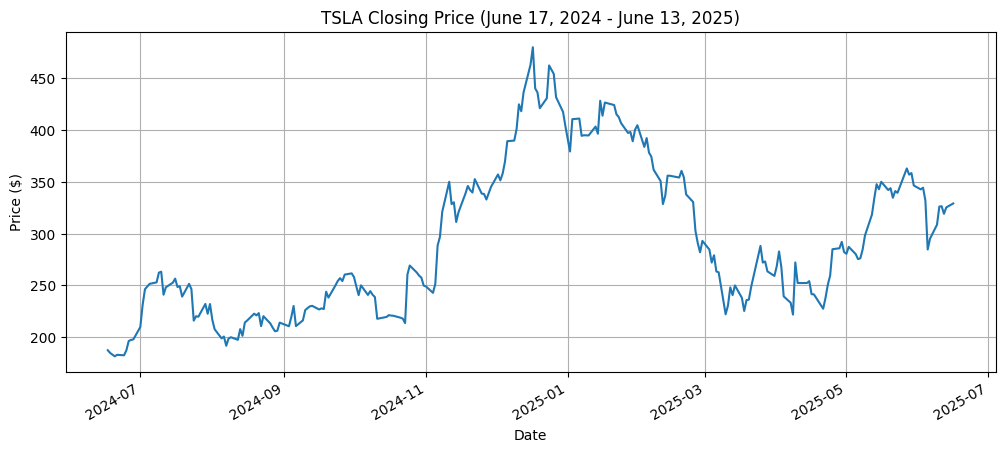

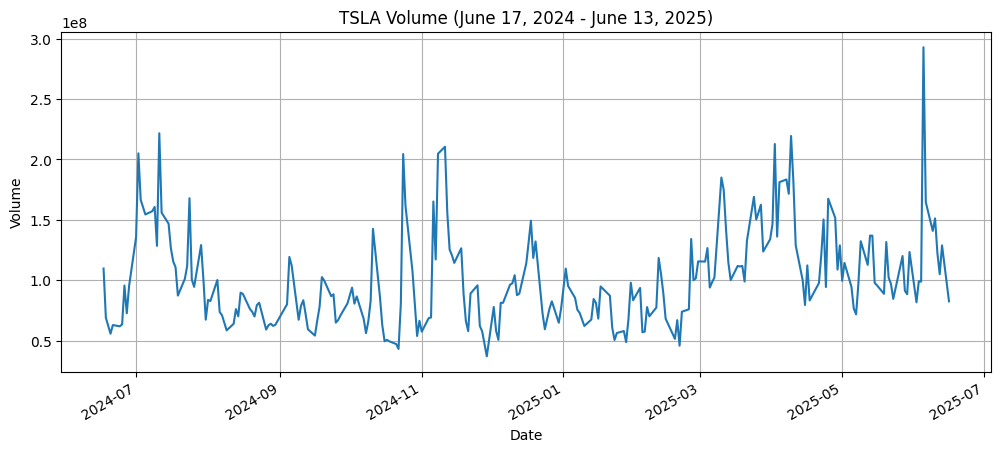

In [13]:
# Plot closing price
plt.figure(figsize=(12, 5))
df['close'].plot(title=f"{stock_symbol} Closing Price (June 17, 2024 - June 13, 2025)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.grid(True)
plt.show()

# Plot volume
plt.figure(figsize=(12, 5))
df['volume'].plot(title=f"{stock_symbol} Volume (June 17, 2024 - June 13, 2025)")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True)
plt.show()

## Summary of findings
- **Row Count**: The DataFrame contains 250 trading days from June 17, 2024, to June 16, 2025, representing approximately one year of market activity. This aligns with the typical number of trading days (around 252) in a year, adjusted for holidays and closures.

- **Date Range**: The DataFrame’s index spans from June 17, 2024, to June 16, 2025, covering a total of 364 days, including weekends and non-trading days. The 250 trading days reflect the exclusion of weekends and specific holidays, consistent with U.S. stock market conventions (e.g., NASDAQ). This range provides a comprehensive dataset for analyzing Tesla’s price and volume trends over the period.

- **Date Gaps**: The index correctly excludes two non-trading holidays: January 9, 2025 (National Day of Mourning for former President James Earl Carter, Jr., following his passing on December 29, 2024) and April 18, 2025 (Good Friday, a traditional market closure). It appropriately includes October 14, 2024 (Columbus Day) and November 11, 2024 (Veterans Day), which are trading days for equity markets like NASDAQ, though bond markets may close. These inclusions and exclusions validate the dataset’s adherence to market-specific trading calendars, ensuring data integrity for modeling.

- **Missing Values**: No missing values were detected across all columns (open, high, low, close, volume, mo5), ensuring a complete dataset for analysis and prediction.

- **Data Types**: All numerical columns (open, high, low, close, volume, mo5) are stored as float64, providing sufficient precision for financial data. The index is of type datetime64, enabling time-series operations and accurate date-based slicing (e.g., 2025-06-05).

- **Anomalies**: A significant outlier was identified in the volume column on June 5, 2025, with a value of 292,818,655 for TSLA (mean: 100,814,958, std: 39,521,561). This outlier was validated with:

    - **Z-Score**: 4.858, indicating it is over 4.8 standard deviations above the mean (100,814,958.224), confirming its extremity.

    - **IQR**: Exceeds the upper bound (Q3 + 1.5 * IQR), consistent with initial outlier detection.

    - **Data Validation**: Matches NASDAQ’s reported volume, while Yahoo Finance reported 287,499,800 (~1.8% lower), likely due to an adjustment or error. The NASDAQ alignment prioritizes the dataset’s value.

    - **Event Context**: Driven by a major event—U.S. President Donald Trump’s threat to pull government contracts from Elon Musk's companies, and Tesla being one of his companies caused a high-volume sell-off and a ~14.2% price drop (close: 332.05 to 284.70).

    - **Action Taken**: Flagged with a boolean column `is_outlier` (True for June 5, 2025) and retained for modeling to reflect real market dynamics.

- **Visualization**:

    - **Closing Price Trend**: The closing price trend shows a rise from $181.57 (min) in mid-2024 to a peak of $479.86 (max) in early 2025, followed by a decline to ~$300–$350 by June 2025. A sharp drop (14.2%) occurred on June 5, 2025, aligning with the volume spike, followed by partial recovery or stabilization toward June 13, 2025. This suggests event-driven volatility and potential mean-reversion patterns.

    - **Volume Trend**: The trading volume distribution is right-skewed, with a median of approximately 93.9 million shares and a mean of approximately 100.8 million shares. This suggests that while most trading days have volumes around 93.9 million, occasional days with significantly higher volumes pull the average upward.

    - **Volume Spike**: A drastic increase to ~2.9 billion on June 5, 2025, stands out against a baseline of 0.5–1.5 billion, with other minor spikes (e.g., mid-2024, early 2025). This indicates Tesla’s stock is highly sensitive to news, with June 5 as the most extreme outlier.

    - **Additional Patterns**: Periodic volume spikes and price fluctuations suggest seasonal or event-driven trends (e.g., earnings, product news), warranting further investigation of other peak dates.


**Conclusion**: 
The analysis confirms a robust dataset with 250 trading days from June 17, 2024, to June 16, 2025, with no missing values and adherence to market trading calendars. The primary anomaly, a volume outlier of 292,818,655 on June 5, 2025, is validated by a z-score of 4.858 and IQR, supported by NASDAQ data, and linked to a significant event (Trump’s threat to Tesla contracts), which triggered a ~14.2% price drop. Visualizations reveal event-driven volatility, a price peak-to-decline trend, and potential recovery patterns, with other volume spikes suggesting additional event sensitivity. The outlier is flagged as is_outlier and retained for modeling to capture real market behavior. Future steps include testing the model’s sensitivity to the outlier, exploring lagged effects, and investigating other high-volume dates for enhanced predictive accuracy.